<a href="https://nbviewer.jupyter.org/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Morph_viz/All_things_morphology.ipynb">
   <img align="left" 
      src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

## Visualizing the Allen Institute .swc morphologies with different customizations

In [6]:
%matplotlib inline
from ateamopt.morph_handler import MorphHandler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ateamopt.utils import utility
from allensdk.core.cell_types_cache import CellTypesCache
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

### Get Mophology

In [7]:
def get_morph_path(cell_id):
    ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
    morph_path = f"cell_types/{cell_id}.swc"
    ctc.get_reconstruction(int(cell_id), file_name=morph_path)
    return morph_path 

### Data paths

In [8]:
np.random.seed(0)
data_path = os.path.join(os.getcwd(),os.pardir,os.pardir,'assets','aggregated_data')
cre_coloring_filename = os.path.join(data_path,'rnaseq_sorted_cre.pkl')
cre_color_dict = utility.load_pickle(cre_coloring_filename)
cre_color_dict['Other'] = (0,0,0)

depth_data_filename = os.path.join(data_path,'mouse_me_and_met_avg_layer_depths.json') # Average layerwise depths for mouse
depth_data = utility.load_json(depth_data_filename)
total_depth = depth_data['wm']

# Cells are chosen to sample from diverse types within each layer
cell_id_dict = {'1':['574734127','564349611','475585413','555341581','536951541'],
                '2/3':['485184849','475515168','485468180','476087653','571306690'],
                '4':['483101699','602822298','490205998','569723367','324257146'],
                '5':['479225052','607124114','515249852','488683425','569998790'],
                '6a':['490259231','473564515','561985849','578938153','471789504'],
                '6b':['589128331','574993444','510136749','509881736','590558808']}

# Get normalized depth metadata for individual cells

ctc = CellTypesCache()
cells_allensdk = ctc.get_cells(species = ['Mus musculus'],simple = False)
sdk_data = pd.DataFrame(cells_allensdk)
sdk_data['specimen__id'] = sdk_data['specimen__id'].astype(str)


### Figure co-ordinates

In [9]:
ylim_min,ylim_max =-200, 1200
soma_loc_x = 0
sigma_layer = 50
soma_loc_displacement_x = 500
unique_layers = sorted(sdk_data.structure__layer.unique().tolist())

layer_dist = {layer_ : i*soma_loc_displacement_x for i,layer_ in enumerate(unique_layers)}

### Generate the laminar morphology figure

2021-11-11 21:25:39,195 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/591276336
2021-11-11 21:25:41,493 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/658102912
2021-11-11 21:25:43,181 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657300335
2021-11-11 21:25:44,654 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/570682723
2021-11-11 21:25:45,990 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657248126
2021-11-11 21:25:47,737 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657298381
2021-11-11 21:25:49,467 allensdk.api.api.retrieve_fi

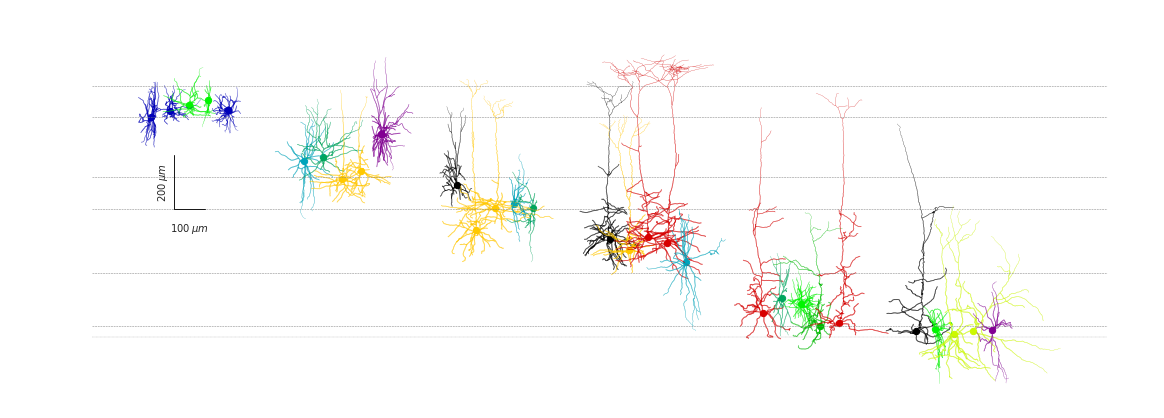

In [10]:
sns.set(style='whitegrid')
fig,ax = plt.subplots()
figname = os.path.join('figures','morph_layerwise.png')
utility.create_filepath(figname)

for layer_name,cell_id_list in cell_id_dict.items():
    num_cells = len(cell_id_list)
    dist_x = np.linspace(-125,125,num_cells)
    for kk,cell_id in enumerate(cell_id_list):
        metadata= sdk_data.loc[sdk_data.specimen__id==cell_id,['csl__normalized_depth','line_name',
                                                               'structure__layer']]
        norm_depth = metadata.csl__normalized_depth.tolist()[0]
        cre = metadata.line_name.tolist()[0]
        layer = metadata.structure__layer.tolist()[0]
        color = cre_color_dict[cre] if cre in cre_color_dict.keys() else cre_color_dict['Other']
        color_dict = {swc_sect_indx:color for swc_sect_indx in range(1,5)}
    
        loc_x = layer_dist[layer]+dist_x[kk]
        soma_loc = np.array([loc_x,(1-norm_depth)*total_depth])
        soma_loc
        morph_path = get_morph_path(cell_id)
        
        morph_handler = MorphHandler(morph_path)
        morph_data,morph_apical,morph_axon,morph_dist_arr = morph_handler.get_morph_coords()
        
        # Rotate morphology to appear upright                            
        theta,axis_of_rot = morph_handler.calc_rotation_angle(morph_data,morph_apical)
        
        ax = morph_handler.draw_morphology_2D(theta,axis_of_rot,reject_axon=True,
                                  soma_loc=soma_loc,color_dict=color_dict,
                                  morph_dist_arr=morph_dist_arr,ax=ax)  # soma_rad = 10 in manuscript
        
        
ax.set_ylim([ylim_min,ylim_max])
xmin,xmax = ax.get_xlim()
for layer_ in unique_layers:
    layer_height = total_depth if layer_ == '1' else total_depth-depth_data[layer_] 
    ax.hlines(layer_height,xmin,xmax,colors='grey',lw=.5,linestyles='dashed')

# Add scale
ax.plot([-50,50],[total_depth-depth_data['5'], total_depth-depth_data['5']],
        lw=1,color='k')
ax.text(0, total_depth-depth_data['5']-80, '$100\:\mu m$',fontsize=10,
        horizontalalignment='center')
ax.plot([-50,-50],[total_depth-depth_data['5'], total_depth-depth_data['5']+200],
        lw=1,color='k')
ax.text(-110, total_depth-depth_data['5']+100, '$200\:\mu m$',fontsize=10,
        verticalalignment='center',rotation=90)

ax.hlines(0,xmin,xmax,colors='grey',lw=.25,linestyles='dashed')
ax.axis('off')
fig.set_size_inches(20,7) # (14,5) in the manuscript
fig.savefig(figname,bbox_inches='tight',dpi=500)


plt.show()